In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-03-03 17:27:55.632326: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'image.npy')
labels_file = os.path.join(DATAPATH, 'label.npy')

In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
images.ndim, labels.ndim

(3, 3)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
p = np.random.permutation(len(images))

In [8]:
images = images[p]
labels = labels[p]

In [9]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [10]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [11]:
images.shape

(14893, 512, 512, 1)

In [12]:
labels.shape

(14893, 512, 512, 1)

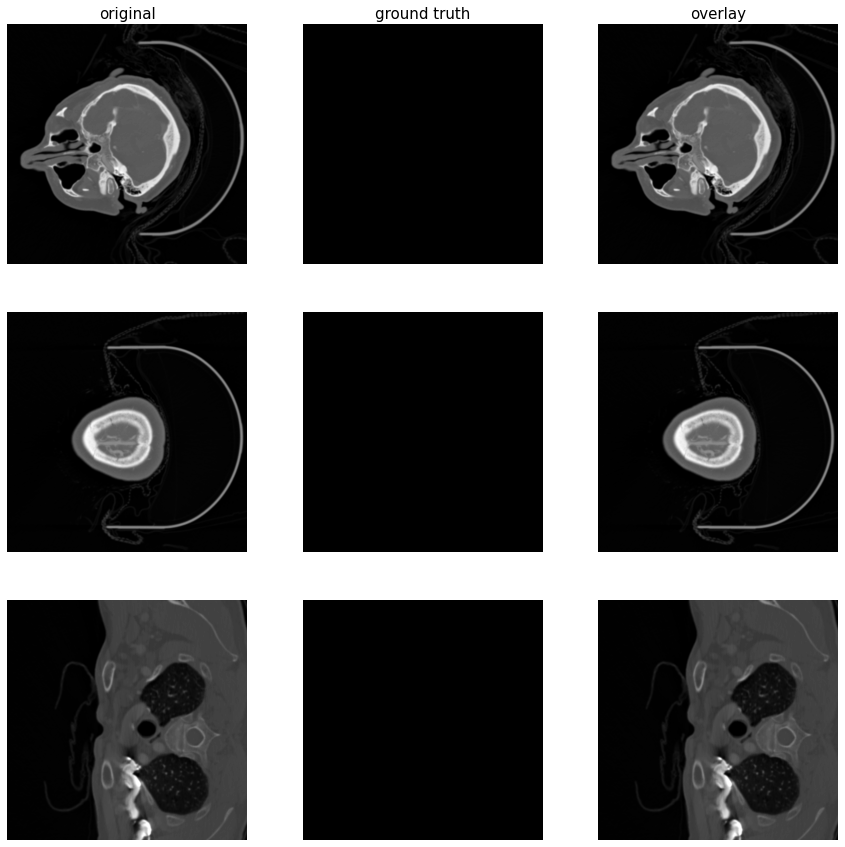

In [13]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [14]:
#X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [14]:
import json

In [15]:
with open("images_data_v2.json", "r") as fp:
    image_data = json.load(fp)
with open("labels_data_v2.json", "r") as fp:
    label_data = json.load(fp)

In [16]:
image_data['82']

12029

In [17]:
label_data['82']

12029

In [18]:
X_train = images[0:image_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[image_data['82']:]
y_val = labels[label_data['82']:]

In [19]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-03-03 17:28:45.812737: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-03 17:28:45.826331: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-03 17:28:45.826387: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: chimera13
2023-03-03 17:28:45.826393: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: chimera13
2023-03-03 17:28:45.826705: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.172.1
2023-03-03 17:28:45.826722: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.172.1
2023-03-03 17:28:45.826727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 450.172.1
2023-03-03 17:28:45.827289: I tensorflow/core/platform/cpu_fe

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [20]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [21]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [23]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=64,
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-03-03 17:29:18.513347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-03 17:29:18.533225: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200
  1/188 [..............................] - ETA: 21:04:55 - loss: 1.1871 - iou: 6.0222e-05 - iou_thresholded: 5.6264e-05

KeyboardInterrupt: 

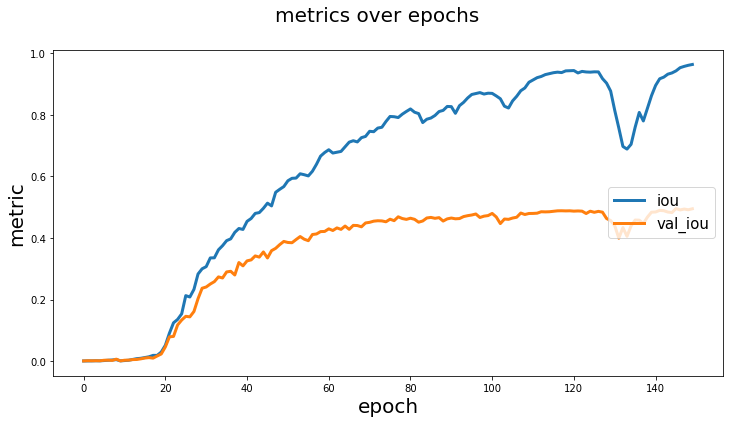

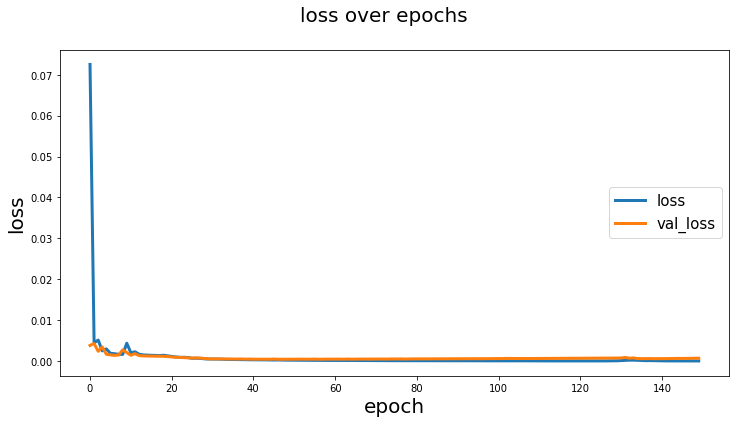

In [20]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [21]:
y_pred = model.predict(X_val)

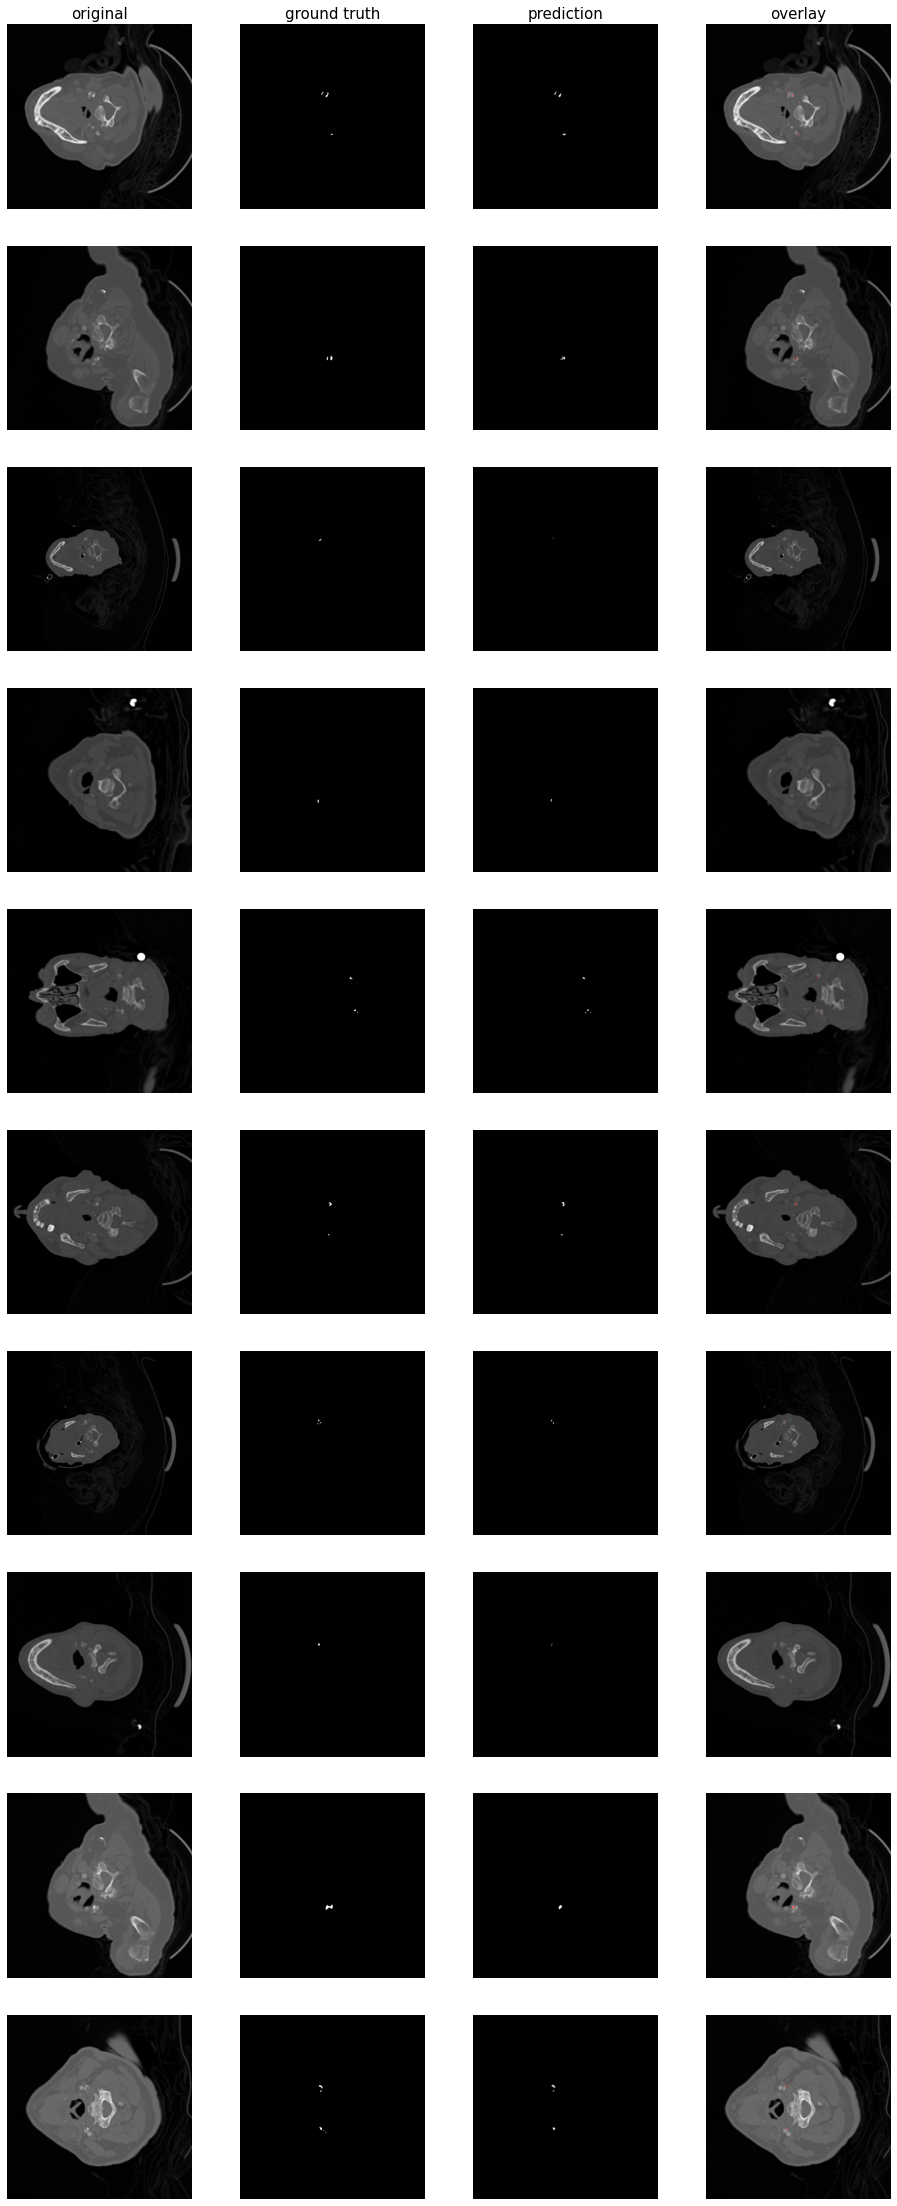

In [22]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [23]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

4/4 [==============================] - 2s 335ms/step - loss: 6.7572e-04 - iou: 0.5032 - iou_thresholded: 0.5127
